In [7]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# set random seeds
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
def generate_data(n_samples=1000):
    X1 = np.random.uniform(-5, 5, n_samples)
    X2 = np.random.uniform(-5, 5, n_samples)
    X3 = np.random.uniform(-5, 5, n_samples)

    y = 2 * np.sin(X1) + 0.5 * X2**2 + 0.3 * X3**3 + np.cos(X1 * X2) + np.random.normal(0, 0.2, n_samples)
    X = np.column_stack((X1, X2, X3)).astype(np.float32)
    y = y.reshape(-1, 1).astype(np.float32)

    return X, y

# generate datasets
X_train, y_train = generate_data(1000)
X_val, y_val = generate_data(200)
X_test, y_test = generate_data(200)

In [9]:
class LowLevelModel:
    def __init__(self, learning_rate=0.001):
        # weight & bias initialization
        self.W1 = tf.Variable(tf.random.normal([3, 64]) * tf.sqrt(2. / 3))
        self.b1 = tf.Variable(tf.zeros([64]))

        self.W2 = tf.Variable(tf.random.normal([64, 32]) * tf.sqrt(2. / 64))
        self.b2 = tf.Variable(tf.zeros([32]))

        self.W3 = tf.Variable(tf.random.normal([32, 16]) * tf.sqrt(2. / 32))
        self.b3 = tf.Variable(tf.zeros([16]))

        self.W4 = tf.Variable(tf.random.normal([16, 1]) * tf.sqrt(2. / 16))
        self.b4 = tf.Variable(tf.zeros([1]))

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    def forward(self, x, training=True):
        z1 = tf.einsum('ij,jk->ik', x, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        if training: a1 = tf.nn.dropout(a1, rate=0.2)

        z2 = tf.einsum('ij,jk->ik', a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        if training: a2 = tf.nn.dropout(a2, rate=0.2)

        z3 = tf.einsum('ij,jk->ik', a2, self.W3) + self.b3
        a3 = tf.nn.relu(z3)
        if training: a3 = tf.nn.dropout(a3, rate=0.2)

        out = tf.einsum('ij,jk->ik', a3, self.W4) + self.b4
        return out

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            y_pred = self.forward(x)
            loss = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2,
                                     self.W3, self.b3, self.W4, self.b4])
        self.optimizer.apply_gradients(zip(grads, [self.W1, self.b1, self.W2, self.b2,
                                                   self.W3, self.b3, self.W4, self.b4]))
        return loss

In [10]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=200):
    losses = []
    for epoch in range(epochs):
        loss = model.train_step(X_train, y_train)
        losses.append(loss.numpy())

        if epoch % 20 == 0:
            val_pred = model.forward(X_val, training=False)
            val_loss = tf.reduce_mean(tf.square(val_pred - y_val)).numpy()
            print(f"Epoch {epoch}: Train Loss = {loss.numpy():.4f}, Val Loss = {val_loss:.4f}")

    return losses

In [11]:
def plot_results(model, X_test, y_test, losses):
    # training loss
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")

    # prediction
    y_pred = model.forward(X_test, training=False).numpy()

    # 4D Scatter
    ax = plt.subplot(132, projection='3d')
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                         c=y_pred[:, 0], cmap='viridis')
    plt.colorbar(scatter)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.set_title("4D Scatter (Color = Predicted)")

    # actual vs predicted
    plt.subplot(133)
    plt.scatter(y_test.numpy(), y_pred, alpha=0.6)
    min_val = tf.reduce_min(y_test).numpy()
    max_val = tf.reduce_max(y_test).numpy()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")

    plt.tight_layout()
    plt.show()

Epoch 0: Train Loss = 268.1316, Val Loss = 274.9184
Epoch 20: Train Loss = 197.8072, Val Loss = 205.1069
Epoch 40: Train Loss = 124.3313, Val Loss = 115.4931
Epoch 60: Train Loss = 80.0222, Val Loss = 59.7265
Epoch 80: Train Loss = 70.0803, Val Loss = 49.0238
Epoch 100: Train Loss = 56.5626, Val Loss = 43.4344
Epoch 120: Train Loss = 57.2173, Val Loss = 38.7923
Epoch 140: Train Loss = 51.0588, Val Loss = 36.1507
Epoch 160: Train Loss = 47.7380, Val Loss = 33.7491
Epoch 180: Train Loss = 50.0994, Val Loss = 32.4572


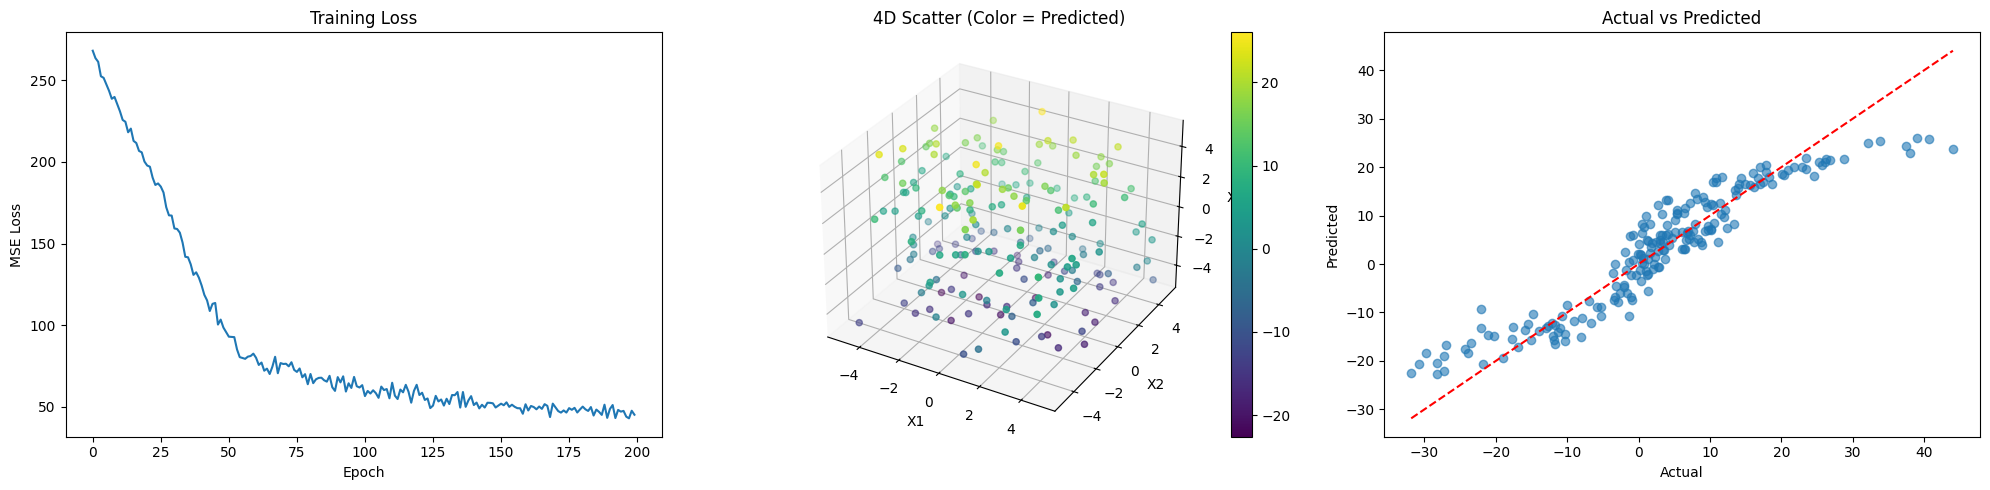

In [12]:
# convert numpy arrays to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# initialize and train model
model = LowLevelModel()
losses = train_model(model, X_train_tf, y_train_tf, X_val_tf, y_val_tf)

# plotting results
plot_results(model, X_test_tf, y_test_tf, losses)

In [13]:
# manual predictions
test_points = np.array([
    [-4, -4, -4],
    [-2, -2, -2],
    [0, 0, 0],
    [2, 2, 2],
    [4, 4, 4]
], dtype=np.float32)

test_tensor = tf.convert_to_tensor(test_points)
preds = model.forward(test_tensor, training=False).numpy()

print("\nTest Predictions:")
for i, (x1, x2, x3) in enumerate(test_points):
    actual = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
    predicted = preds[i][0]
    print(f"Input: ({x1:.1f}, {x2:.1f}, {x3:.1f}) | Prediction: {predicted:.3f} | Actual: {actual:.3f} | Diff: {abs(predicted - actual):.3f}")


Test Predictions:
Input: (-4.0, -4.0, -4.0) | Prediction: -10.037 | Actual: -10.644 | Diff: 0.607
Input: (-2.0, -2.0, -2.0) | Prediction: -4.618 | Actual: -2.872 | Diff: 1.746
Input: (0.0, 0.0, 0.0) | Prediction: 0.173 | Actual: 1.000 | Diff: 0.827
Input: (2.0, 2.0, 2.0) | Prediction: 10.672 | Actual: 5.565 | Diff: 5.107
Input: (4.0, 4.0, 4.0) | Prediction: 21.510 | Actual: 24.729 | Diff: 3.219
